In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.datasets import make_regression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from numpy import mean
from scipy.stats import linregress
from matplotlib.ticker import FormatStrFormatter
from matplotlib import ticker
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_absolute_percentage_error

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [6]:
# data_sgp_sgp_sgp_sgp_sgp reading
data_sgp = pd.read_csv('E:/aabc\myDeepTree\data-240321/sgpTP21.csv')
data_sgp = data_sgp.replace(-9999, float('nan'))
data_sgp.iloc[:, 0] = pd.to_numeric(data_sgp.iloc[:, 0], errors='coerce')
data_sgp = data_sgp.dropna()
data_sgp.columns = [
     'BS_B', 'BS_G', 'BS_R', 'AE_BG', 'AE_BR', 'AE_GR', 'BBS_B', 'BBS_G', 'BBS_R',
    'BSF_B', 'BSF_G', 'BSF_R', 'g_B', 'g_G', 'g_R', 'SSA_B', 'SSA_G', 'SSA_R', 
    'TR_B', 'TR_G', 'TR_R', 'RH', 'BA_B', 'BA_G', 'BA_R','CCN'
]
def remove_outliers(df):
    # Remove outliers using the 3-sigma rule
    for column in df.columns:
        mean = df[column].mean()
        std = df[column].std()
        cutoff = std * 3
        lower = mean - cutoff
        upper = mean + cutoff
        df = df[(df[column] > lower) & (df[column] < upper)]
    return df

# Apply function to remove outliers
data_sgp = remove_outliers(data_sgp)
data_sgp = data_sgp[data_sgp['CCN'] >0]
data_sgp = data_sgp[data_sgp['SSA_B']<1]
data_sgp = data_sgp[data_sgp['SSA_G']<1]
data_sgp = data_sgp[data_sgp['SSA_R']<1]
data_sgp = data_sgp[data_sgp['BA_B']>0]
data_sgp = data_sgp[data_sgp['BA_G']>0]
data_sgp = data_sgp[data_sgp['BA_R']>0]
# data_sgp = data_sgp.loc[0:456806,:]# The first 200,000 groups of data_sgp in the sgp
# data_sgp = data_sgp.sample(n=200000, random_state=2024)
# Prepare features and target variable
X = data_sgp.drop('CCN', axis=1)  # Features
y = data_sgp['CCN']  # Features
X_train_sgp, X_test_sgp, y_train_sgp, y_test_sgp = train_test_split(X, y, test_size=0.2, random_state=2024)
data_sgp


,BS_B,BS_G,BS_R,AE_BG,AE_BR,AE_GR,BBS_B,BBS_G,BBS_R,BSF_B,...,SSA_G,SSA_R,TR_B,TR_G,TR_R,RH,BA_B,BA_G,BA_R,CCN
5,36.315190,27.969503,18.052286,1.991714,2.103956,2.197353,3.773548,3.464851,2.792726,0.103911,...,0.940363,0.927178,0.707051,0.762839,0.817633,52.383335,2.683741,2.244908,1.734303,798.650658
6,34.604317,26.661331,17.208166,1.988988,2.103031,2.197925,4.021618,3.626426,2.454104,0.116217,...,0.940014,0.925638,0.706824,0.762624,0.817446,51.391666,2.557827,2.150215,1.683969,912.411032
7,33.509308,25.435738,16.426088,2.102668,2.138113,2.167607,3.899488,3.452181,2.591593,0.116370,...,0.937432,0.923040,0.706382,0.762212,0.817086,51.825000,2.588222,2.127653,1.657185,844.085035
8,33.598194,25.436905,16.117731,2.122524,2.207794,2.278747,3.455863,3.155629,2.477978,0.102859,...,0.924001,0.904566,0.705890,0.761756,0.816688,51.091667,3.012022,2.518159,1.981802,863.700829
9,34.568165,26.600248,17.783026,1.998512,1.989103,1.981274,4.173240,3.263742,2.680168,0.120725,...,0.920219,0.904761,0.705331,0.761233,0.816221,52.550000,3.302551,2.745786,2.179066,881.721786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728948,5.385745,4.396246,3.392887,1.548425,1.364981,1.212338,0.671493,0.640184,0.514532,0.124680,...,0.848164,0.849899,0.651316,0.699742,0.753117,17.466667,0.996367,0.838645,0.645862,247.710011
728949,6.156305,5.041541,3.635393,1.523715,1.583064,1.632448,0.936615,0.803642,0.951859,0.152139,...,0.848593,0.841401,0.651155,0.699593,0.752984,17.600000,1.145672,0.959065,0.734431,249.111098
728952,6.648797,5.497541,4.352057,1.450262,1.248510,1.080632,0.980080,1.053014,1.061275,0.147407,...,0.844928,0.848537,0.650630,0.699100,0.752537,17.783333,1.306583,1.071775,0.835994,254.526510
728953,6.622446,5.573394,4.833484,1.315449,0.901117,0.556353,0.756845,0.829249,1.159335,0.114285,...,0.845310,0.841636,0.650436,0.698920,0.752375,17.733334,1.276868,1.079658,0.969621,255.458028


In [7]:
# data_asi_asi_asi_asi_asi reading
data_asi = pd.read_csv('E:/aabc\myDeepTree\data-240321/asiTP.csv')
data_asi = data_asi.replace(-9999, float('nan'))
data_asi.iloc[:, 0] = pd.to_numeric(data_asi.iloc[:, 0], errors='coerce')
data_asi = data_asi.dropna()
data_asi.columns = [
     'CCN','BS_B', 'BS_G', 'BS_R', 'AE_BG', 'AE_BR', 'AE_GR', 'BBS_B', 'BBS_G', 'BBS_R',
    'BSF_B', 'BSF_G', 'BSF_R', 'g_B', 'g_G', 'g_R', 'SSA_B', 'SSA_G', 'SSA_R', 
    'TR_B', 'TR_G', 'TR_R', 'RH', 'BA_B', 'BA_G', 'BA_R'
]
def remove_outliers(df):
    # Remove outliers using the 3-sigma rule
    for column in df.columns:
        mean = df[column].mean()
        std = df[column].std()
        cutoff = std * 3
        lower = mean - cutoff
        upper = mean + cutoff
        df = df[(df[column] > lower) & (df[column] < upper)]
    return df

# Apply function to remove outliers
data_asi = remove_outliers(data_asi)
data_asi = data_asi[data_asi['CCN'] >0]
data_asi = data_asi[data_asi['SSA_B']<1]
data_asi = data_asi[data_asi['SSA_G']<1]
data_asi = data_asi[data_asi['SSA_R']<1]
data_asi = data_asi[data_asi['BA_B']>0]
data_asi = data_asi[data_asi['BA_G']>0]
data_asi = data_asi[data_asi['BA_R']>0]
data_asi = data_asi[data_asi['AE_BG']>0]
data_asi = data_asi[data_asi['AE_BR']>0]
data_asi = data_asi[data_asi['AE_GR']>0]
# data_asi = data_asi.loc[0:456806,:]# The first 200,000 groups of data_asi in the asi
# data_asi = data_asi.sample(n=200000, random_state=2024)
# Prepare features and target variable
X = data_asi.drop('CCN', axis=1)  # Features
y = data_asi['CCN']  # Features
X_train_asi, X_test_asi, y_train_asi, y_test_asi = train_test_split(X, y, test_size=0.2, random_state=2024)
data_asi


,CCN,BS_B,BS_G,BS_R,AE_BG,AE_BR,AE_GR,BBS_B,BBS_G,BBS_R,...,SSA_B,SSA_G,SSA_R,TR_B,TR_G,TR_R,RH,BA_B,BA_G,BA_R
1,99.866000,23.375761,22.696941,20.890125,0.224779,0.349093,0.452534,3.506959,3.079141,3.168227,...,0.978253,0.981265,0.983799,0.971444,0.969522,0.966401,67.191666,0.923225,0.826057,0.707971
2,96.089167,21.505592,21.363607,18.998453,0.050527,0.406966,0.703559,2.714427,2.553211,2.777568,...,0.950047,0.953130,0.949358,0.971260,0.969354,0.966250,69.525000,1.520157,1.438961,1.365382
3,96.167167,19.118690,18.185902,16.474014,0.381528,0.452928,0.512339,2.464471,2.417343,2.337645,...,0.944280,0.942133,0.938591,0.971025,0.969126,0.966026,69.550000,1.479760,1.454632,1.388140
4,95.601167,15.857728,14.828381,13.630428,0.511916,0.446571,0.392197,1.381179,1.378797,1.677934,...,0.974986,0.975753,0.976643,0.970855,0.968962,0.965878,67.841670,0.683579,0.628171,0.566406
6,65.715385,9.700858,9.682875,8.276752,0.014152,0.526901,0.953558,1.075042,1.247765,1.257902,...,0.985185,0.988834,0.988806,0.923897,0.926015,0.928233,61.441666,0.308841,0.273357,0.236302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485048,0.373828,8.431938,6.773862,3.999436,1.670089,2.296070,2.816948,1.126593,1.193067,0.927468,...,0.844806,0.841283,0.794991,0.999703,0.999751,0.999814,55.400000,1.746308,1.439267,1.137069
485049,0.567981,8.952989,6.936341,4.172319,1.946648,2.323871,2.637758,1.054484,0.794995,0.509370,...,0.859341,0.851866,0.816160,0.999431,0.999528,0.999638,55.550000,1.669551,1.367980,1.045255
485050,0.485132,8.518941,6.414651,3.706067,2.163990,2.528604,2.831999,0.485955,0.739108,0.929532,...,0.849920,0.839433,0.790281,0.999156,0.999304,0.999466,55.600000,1.702796,1.380826,1.082406
485051,0.350301,7.881830,6.565426,4.074286,1.393877,2.040656,2.578840,0.680449,0.940279,0.706358,...,0.842907,0.843351,0.815168,0.998889,0.999086,0.999301,55.600000,1.653102,1.374429,1.026733


In [8]:
# data_ena_ena_ena_ena_ena reading
data_ena = pd.read_csv('E:/aabc\myDeepTree\data-240321/enaTP.csv')
data_ena = data_ena.replace(-9999, float('nan'))
data_ena.iloc[:, 0] = pd.to_numeric(data_ena.iloc[:, 0], errors='coerce')
data_ena = data_ena.dropna()
data_ena.columns = [
     'CCN','BS_B', 'BS_G', 'BS_R', 'AE_BG', 'AE_BR', 'AE_GR', 'BBS_B', 'BBS_G', 'BBS_R',
    'BSF_B', 'BSF_G', 'BSF_R', 'g_B', 'g_G', 'g_R', 'SSA_B', 'SSA_G', 'SSA_R', 
    'TR_B', 'TR_G', 'TR_R', 'RH', 'BA_B', 'BA_G', 'BA_R'
]
def remove_outliers(df):
    # Remove outliers using the 3-sigma rule
    for column in df.columns:
        mean = df[column].mean()
        std = df[column].std()
        cutoff = std * 3
        lower = mean - cutoff
        upper = mean + cutoff
        df = df[(df[column] > lower) & (df[column] < upper)]
    return df

# Apply function to remove outliers
data_ena = remove_outliers(data_ena)
data_ena = data_ena[data_ena['CCN'] >0]
data_ena = data_ena[data_ena['SSA_B']<1]
data_ena = data_ena[data_ena['SSA_G']<1]
data_ena = data_ena[data_ena['SSA_R']<1]
data_ena = data_ena[data_ena['BA_B']>0]
data_ena = data_ena[data_ena['BA_G']>0]
data_ena = data_ena[data_ena['BA_R']>0]
data_ena = data_ena[data_ena['AE_BG']>0]
data_ena = data_ena[data_ena['AE_BR']>0]
data_ena = data_ena[data_ena['AE_GR']>0]
# data_ena = data_ena.loc[0:456806,:]# The first 200,000 groups of data_ena in the ena
# data_ena = data_ena.sample(n=200000, random_state=2024)
# Prepare features and target variable
X = data_ena.drop('CCN', axis=1)  # Features
y = data_ena['CCN']  # Features
X_train_ena, X_test_ena, y_train_ena, y_test_ena = train_test_split(X, y, test_size=0.2, random_state=2024)
data_ena


,CCN,BS_B,BS_G,BS_R,AE_BG,AE_BR,AE_GR,BBS_B,BBS_G,BBS_R,...,SSA_B,SSA_G,SSA_R,TR_B,TR_G,TR_R,RH,BA_B,BA_G,BA_R
6,188.570519,12.201920,11.268949,10.160663,0.606712,0.541549,0.487326,1.555767,1.884566,2.258289,...,0.981434,0.982776,0.990027,0.834811,0.855457,0.879395,56.208332,0.370999,0.345914,0.237489
10,192.804885,5.078589,4.006073,2.120290,1.809419,2.705262,3.450691,0.792668,0.703125,0.462293,...,0.984197,0.974434,0.949172,0.834690,0.855335,0.879275,55.816666,0.167970,0.175317,0.152363
12,175.663232,5.378540,3.941111,2.279664,2.371816,2.592139,2.775469,0.718397,0.601325,0.668369,...,0.980835,0.973219,0.955878,0.834643,0.855291,0.879240,55.700000,0.197908,0.177702,0.146475
13,182.135887,4.617376,3.719979,2.543268,1.648376,1.800863,1.927746,0.806420,0.568288,0.399561,...,0.981202,0.975082,0.945963,0.834622,0.855271,0.879218,55.516666,0.167017,0.159441,0.191103
14,189.717088,4.981643,3.936539,2.525809,1.795965,2.060050,2.279795,0.105942,0.355360,0.264591,...,0.985124,0.975558,0.955459,0.834605,0.855253,0.879197,55.500000,0.159984,0.166997,0.163124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881943,527.073848,35.876736,28.738312,20.026070,1.692230,1.751611,1.801022,3.576501,3.499958,3.341776,...,0.969452,0.965660,0.962408,0.792250,0.812105,0.837142,53.616665,1.723327,1.510914,1.130054
881968,524.666357,34.861960,28.206255,20.362028,1.615914,1.609254,1.603713,3.668443,3.311346,3.349562,...,0.972035,0.968592,0.966596,0.997526,0.997744,0.998039,54.500000,1.618409,1.424886,1.076585
881989,592.978897,27.580744,21.472673,13.045682,1.909453,2.278582,2.585734,2.569013,2.255573,2.396343,...,0.958757,0.952543,0.937317,0.990886,0.991901,0.993212,52.483334,1.698597,1.477261,1.129832
881991,572.935669,26.647186,21.258610,12.825631,1.723225,2.241411,2.672593,2.625459,2.252750,2.056174,...,0.959416,0.953635,0.936465,0.990357,0.991442,0.992811,52.725000,1.619558,1.435476,1.123681


In [9]:
# data_guc_guc_guc_guc_guc reading
data_guc = pd.read_csv('E:/aabc\myDeepTree\data-240321/gucTP.csv')
data_guc = data_guc.replace(-9999, float('nan'))
data_guc.iloc[:, 0] = pd.to_numeric(data_guc.iloc[:, 0], errors='coerce')
data_guc = data_guc.dropna()
data_guc.columns = [
     'CCN','BS_B', 'BS_G', 'BS_R', 'AE_BG', 'AE_BR', 'AE_GR', 'BBS_B', 'BBS_G', 'BBS_R',
    'BSF_B', 'BSF_G', 'BSF_R', 'g_B', 'g_G', 'g_R', 'SSA_B', 'SSA_G', 'SSA_R', 
    'TR_B', 'TR_G', 'TR_R', 'RH', 'BA_B', 'BA_G', 'BA_R'
]
def remove_outliers(df):
    # Remove outliers using the 3-sigma rule
    for column in df.columns:
        mean = df[column].mean()
        std = df[column].std()
        cutoff = std * 3
        lower = mean - cutoff
        upper = mean + cutoff
        df = df[(df[column] > lower) & (df[column] < upper)]
    return df

# Apply function to remove outliers
data_guc = remove_outliers(data_guc)
data_guc = data_guc[data_guc['CCN'] >0]
data_guc = data_guc[data_guc['SSA_B']<1]
data_guc = data_guc[data_guc['SSA_G']<1]
data_guc = data_guc[data_guc['SSA_R']<1]
data_guc = data_guc[data_guc['BA_B']>0]
data_guc = data_guc[data_guc['BA_G']>0]
data_guc = data_guc[data_guc['BA_R']>0]
data_guc = data_guc[data_guc['AE_BG']>0]
data_guc = data_guc[data_guc['AE_BR']>0]
data_guc = data_guc[data_guc['AE_GR']>0]
# data_guc = data_guc.loc[0:456806,:]# The first 200,000 groups of data_guc in the guc
# data_guc = data_guc.sample(n=200000, random_state=2024)
# Prepare features and target variable
X = data_guc.drop('CCN', axis=1)  # Features
y = data_guc['CCN']  # Features
X_train_guc, X_test_guc, y_train_guc, y_test_guc = train_test_split(X, y, test_size=0.2, random_state=2024)
data_guc


,CCN,BS_B,BS_G,BS_R,AE_BG,AE_BR,AE_GR,BBS_B,BBS_G,BBS_R,...,SSA_B,SSA_G,SSA_R,TR_B,TR_G,TR_R,RH,BA_B,BA_G,BA_R
9,567.910617,55.117252,43.960804,27.433380,1.725078,2.129572,2.466151,6.214628,4.835032,4.199146,...,0.996957,0.993185,0.981597,0.934336,0.943144,0.953586,32.750000,1.108316,1.064827,1.005721
115,491.612221,63.674225,49.834415,31.511812,1.869311,2.132469,2.351442,7.076651,5.365071,4.464237,...,0.958183,0.952673,0.938560,0.940617,0.949528,0.960026,33.733334,3.934397,3.398772,2.668036
116,504.542269,67.234930,52.973976,32.136272,1.818345,2.253974,2.616462,6.625530,5.919486,4.691011,...,0.957728,0.952304,0.934589,0.940074,0.949049,0.959642,33.550000,4.186866,3.635862,2.871833
117,549.155239,77.575810,59.809303,37.609780,1.983881,2.188143,2.358109,7.647809,6.320363,5.286356,...,0.960888,0.955593,0.940851,0.939470,0.948525,0.959218,33.600000,4.562293,3.883175,3.084042
118,544.227930,73.364655,57.719060,35.774790,1.829503,2.186124,2.482868,7.477943,6.451732,5.311398,...,0.959849,0.955232,0.941418,0.938861,0.947994,0.958797,33.600000,4.394901,3.769745,2.910587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61663,118.828535,2.658496,2.136248,1.561916,1.668216,1.583843,1.513636,0.429092,0.424553,0.317157,...,0.954521,0.926627,0.929890,0.829919,0.855731,0.884562,11.033334,0.171758,0.206726,0.145937
61819,165.657559,2.625966,2.059236,1.480587,1.854360,1.700048,1.571646,0.521734,0.341327,0.341199,...,0.941813,0.889058,0.882290,0.992250,0.993156,0.994163,11.483334,0.212637,0.300879,0.229698
61839,153.672413,2.937862,2.363200,1.559320,1.660249,1.922883,2.141421,0.385938,0.356668,0.342058,...,0.945585,0.980836,0.981248,0.991314,0.992205,0.993474,11.400000,0.224794,0.088412,0.057921
61872,172.351058,2.778204,2.255061,1.840278,1.591319,1.193127,0.861793,0.263386,0.340004,0.327558,...,0.937994,0.903028,0.919131,0.989772,0.991138,0.992595,11.483334,0.237051,0.288567,0.198794


In [10]:
np.random.seed(2024)
indices_sgp = np.random.choice(X_test_sgp.shape[0], 3000, replace=False)
selected_X_test_sgp = X_test_sgp.iloc[indices_sgp]

In [11]:
np.random.seed(2024)
indices_asi = np.random.choice(X_test_asi.shape[0], 3000, replace=False)
selected_X_test_asi = X_test_asi.iloc[indices_asi]

In [12]:
# X_test_ena = pd.read_csv('E:/aabc\myDeepTree\data-240321/enaxtest.csv')
# X_test_ena  = X_test_ena.drop(X_test_ena.columns[0], axis=1)
np.random.seed(2024)
indices_ena = np.random.choice(X_test_ena.shape[0], 3000, replace=False)
selected_X_test_ena = X_test_ena.iloc[indices_ena]

In [13]:
np.random.seed(2024)
indices_guc = np.random.choice(X_test_guc.shape[0], 3000, replace=False)
selected_X_test_guc = X_test_guc.iloc[indices_guc]

In [14]:
gucs = np.load('E:/aabc/myDeepTree/data-240806/gucshap_values.npy')
gucsi = np.load('E:/aabc/myDeepTree/data-240806/gucshap_interaction_values.npy')
sgps = np.load('E:/aabc/myDeepTree/data-240806/sgpshap_values.npy')
sgpsi = np.load('E:/aabc/myDeepTree/data-240806/sgpshap_interaction_values.npy')
asis = np.load('E:/aabc/myDeepTree/data-240806/asishap_values.npy')
asisi = np.load('E:/aabc/myDeepTree/data-240806/asishap_interaction_values.npy')
enas = np.load('E:/aabc/myDeepTree/data-240806/enashap_values2.npy')
enasi = np.load('E:/aabc/myDeepTree/data-240806/enashap_interaction_values2.npy')


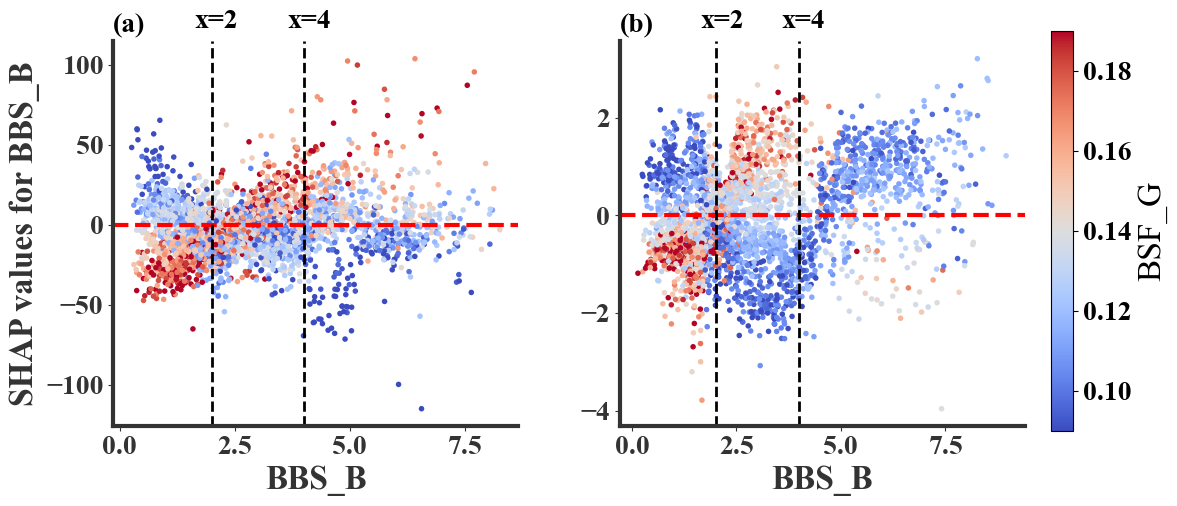

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colorbar as cbar
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

fig.subplots_adjust(right=0.8, wspace=0, hspace=0.2)

shap.dependence_plot(
    "BBS_B",  # key feature
    gucsi[:, :, selected_X_test_guc.columns.get_loc("BSF_G")],  
    selected_X_test_guc,
    interaction_index="BSF_G",  # interactive feature
    ax=axs[1],
    show=False,
    cmap=plt.get_cmap('coolwarm')
)
# cbar = plt.colorbar(cax=axs[0,3], orientation='vertical')
# cbar.ax.set_visible(False)
cbar = axs[1].collections[0].colorbar
cbar.ax.set_visible(False)

axs[1].set_xlabel('BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
axs[1].set_ylabel('', fontsize=2, fontname='Times New Roman', fontweight='bold')
axs[1].spines['bottom'].set_linewidth(3)  
axs[1].spines['top'].set_linewidth(3)  
axs[1].spines['left'].set_linewidth(3) 
axs[1].spines['right'].set_linewidth(3) 
axs[1].tick_params(axis='x', labelsize=20)
axs[1].tick_params(axis='y', labelsize=20)
axs[1].set_title('(b)', loc='left', fontsize=20, fontname='Times New Roman', fontweight='bold')
axs[1].axhline(0, color='red', linestyle='--', linewidth=3)
axs[1].axvline(x=4, color='black', linestyle='--', linewidth=2)
axs[1].axvline(x=2, color='black', linestyle='--', linewidth=2)
axs[1].text(0.2, 1.05, 'x=2', transform=axs[1].transAxes, fontsize=20, fontweight='bold', va='center')
axs[1].text(0.4, 1.05, 'x=4', transform=axs[1].transAxes, fontsize=20, fontweight='bold', va='center')
# axs[0, 0].imshow(data2, cmap='viridis')


shap.dependence_plot(
    "BBS_B",  # key feature
    sgpsi[:, :, selected_X_test_sgp.columns.get_loc("BSF_G")],  
    selected_X_test_sgp,
    interaction_index="BSF_G",  # interactive feature
    ax=axs[0],
    show=False,
    cmap=plt.get_cmap('coolwarm')
)
# cbar = plt.colorbar(cax=axs[0,3], orientation='vertical')
# cbar.ax.set_visible(False)
cbar = axs[0].collections[0].colorbar
cbar.ax.set_visible(False)

axs[0].set_xlabel('BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
axs[0].set_ylabel('SHAP values for BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
axs[0].spines['bottom'].set_linewidth(3)  
axs[0].spines['top'].set_linewidth(3)  
axs[0].spines['left'].set_linewidth(3) 
axs[0].spines['right'].set_linewidth(3) 
axs[0].tick_params(axis='x', labelsize=20)
axs[0].tick_params(axis='y', labelsize=20)
axs[0].set_title('(a)', loc='left', fontsize=20, fontname='Times New Roman', fontweight='bold')
axs[0].axhline(0, color='red', linestyle='--', linewidth=3)
axs[0].axvline(x=4, color='black', linestyle='--', linewidth=2)
axs[0].axvline(x=2, color='black', linestyle='--', linewidth=2)
axs[0].text(-1.05, 1.05, 'x=2', transform=axs[1].transAxes, fontsize=20, fontweight='bold', va='center')
axs[0].text(-0.82, 1.05, 'x=4', transform=axs[1].transAxes, fontsize=20, fontweight='bold', va='center')


cbar_ax = fig.add_axes([0.75, 0.1, 0.015, 0.8])  
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('coolwarm'))
sm.set_array([0.09,0.10,0.12,0.14,0.16,0.18,0.19]) 
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.tick_params(labelsize=20)  
cbar.set_label('BSF_G', fontsize=24) 

# plt.savefig('E:/aabc/summary/fig-240804/sgbsf.png',dpi=300,bbox_inches='tight',pad_inches=0)

plt.show()


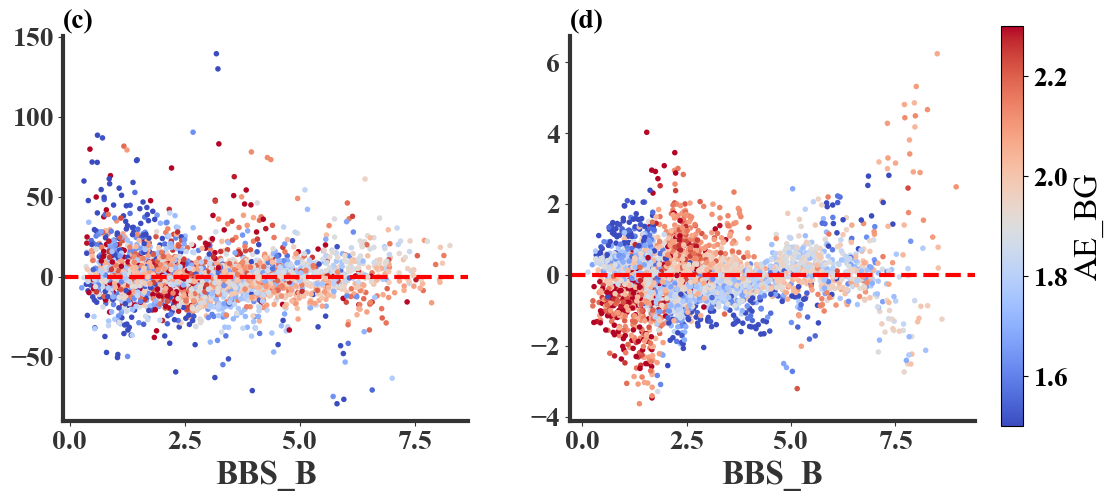

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colorbar as cbar


fig, axs = plt.subplots(1, 2, figsize=(15, 5))


fig.subplots_adjust(right=0.8, wspace=0, hspace=0.2)


shap.dependence_plot(
    "BBS_B",  # key feature
    gucsi[:, :, selected_X_test_guc.columns.get_loc("AE_BG")],  
    selected_X_test_guc,
    interaction_index="AE_BG",  # interactive feature
    ax=axs[1],
    show=False,
    cmap=plt.get_cmap('coolwarm')
)
# cbar = plt.colorbar(cax=axs[0,3], orientation='vertical')
# cbar.ax.set_visible(False)
cbar = axs[1].collections[0].colorbar
cbar.ax.set_visible(False)

axs[1].set_xlabel('BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
axs[1].set_ylabel('', fontsize=24, fontname='Times New Roman', fontweight='bold')
axs[1].spines['bottom'].set_linewidth(3)  
axs[1].spines['top'].set_linewidth(3)  
axs[1].spines['left'].set_linewidth(3) 
axs[1].spines['right'].set_linewidth(3) 
axs[1].tick_params(axis='x', labelsize=20)
axs[1].tick_params(axis='y', labelsize=20)
axs[1].set_title('(d)', loc='left', fontsize=20, fontname='Times New Roman', fontweight='bold')
axs[1].axhline(0, color='red', linestyle='--', linewidth=3)
# axs[0, 0].imshow(data2, cmap='viridis')


shap.dependence_plot(
    "BBS_B",  # key feature
    sgpsi[:, :, selected_X_test_sgp.columns.get_loc("AE_BG")],  
    selected_X_test_sgp,
    interaction_index="AE_BG",  # interactive feature
    ax=axs[0],
    show=False,
    cmap=plt.get_cmap('coolwarm')
)
# cbar = plt.colorbar(cax=axs[0,3], orientation='vertical')
# cbar.ax.set_visible(False)
cbar = axs[0].collections[0].colorbar
cbar.ax.set_visible(False)

axs[0].set_xlabel('BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
axs[0].set_ylabel('', fontsize=24, fontname='Times New Roman', fontweight='bold')
axs[0].spines['bottom'].set_linewidth(3)  
axs[0].spines['top'].set_linewidth(3)  
axs[0].spines['left'].set_linewidth(3) 
axs[0].spines['right'].set_linewidth(3) 
axs[0].tick_params(axis='x', labelsize=20)
axs[0].tick_params(axis='y', labelsize=20)
axs[0].set_title('(c)', loc='left', fontsize=20, fontname='Times New Roman', fontweight='bold')
axs[0].axhline(0, color='red', linestyle='--', linewidth=3)


cbar_ax = fig.add_axes([0.75, 0.1, 0.015, 0.8])  
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('coolwarm'))
sm.set_array([1.5,1.6,1.8,2.0,2.2,2.3])  
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.tick_params(labelsize=20)  
cbar.set_label('AE_BG', fontsize=24)  

# plt.savefig('E:/aabc/summary/fig-240804/sgae.png',dpi=300,bbox_inches='tight',pad_inches=0)

plt.show()


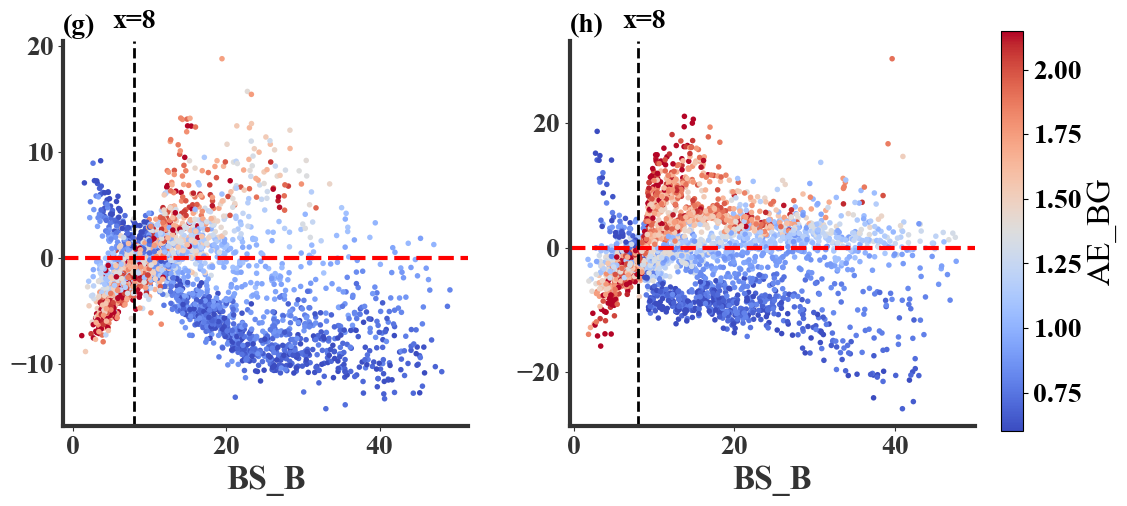

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colorbar as cbar


fig, axs = plt.subplots(1, 2, figsize=(15, 5))


fig.subplots_adjust(right=0.8, wspace=0, hspace=0.2)


shap.dependence_plot(
    "BS_B",  # key feature
    asisi[:, :, selected_X_test_asi.columns.get_loc("AE_BG")],  
    selected_X_test_asi,
    interaction_index="AE_BG",  # interactive feature
    ax=axs[1],
    show=False,
    cmap=plt.get_cmap('coolwarm')
)
# cbar = plt.colorbar(cax=axs[0,3], orientation='vertical')
# cbar.ax.set_visible(False)
cbar = axs[1].collections[0].colorbar
cbar.ax.set_visible(False)

axs[1].set_xlabel('BS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
axs[1].set_ylabel('', fontsize=24, fontname='Times New Roman', fontweight='bold')
axs[1].spines['bottom'].set_linewidth(3)  
axs[1].spines['top'].set_linewidth(3)  
axs[1].spines['left'].set_linewidth(3) 
axs[1].spines['right'].set_linewidth(3) 
axs[1].tick_params(axis='x', labelsize=20)
axs[1].tick_params(axis='y', labelsize=20)
axs[1].set_title('(h)', loc='left', fontsize=20, fontname='Times New Roman', fontweight='bold')
axs[1].axhline(0, color='red', linestyle='--', linewidth=3)
axs[1].axvline(x=8, color='black', linestyle='--', linewidth=2)
axs[0].text(0.13, 1.05, 'x=8', transform=axs[1].transAxes, fontsize=20, fontweight='bold', va='center')
# axs[1].axvline(x=2, color='black', linestyle='--', linewidth=2)
# axs[0, 0].imshow(data2, cmap='viridis')


shap.dependence_plot(
    "BS_B",  # key feature
    enasi[:, :, selected_X_test_ena.columns.get_loc("AE_BG")],  
    selected_X_test_ena,
    interaction_index="AE_BG",  # interactive feature
    ax=axs[0],
    show=False,
    cmap=plt.get_cmap('coolwarm')
)
# cbar = plt.colorbar(cax=axs[0,3], orientation='vertical')
# cbar.ax.set_visible(False)
cbar = axs[0].collections[0].colorbar
cbar.ax.set_visible(False)

axs[0].set_xlabel('BS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
axs[0].set_ylabel('', fontsize=24, fontname='Times New Roman', fontweight='bold')
axs[0].spines['bottom'].set_linewidth(3)  
axs[0].spines['top'].set_linewidth(3)  
axs[0].spines['left'].set_linewidth(3) 
axs[0].spines['right'].set_linewidth(3) 
axs[0].tick_params(axis='x', labelsize=20)
axs[0].tick_params(axis='y', labelsize=20)
axs[0].set_title('(g)', loc='left', fontsize=20, fontname='Times New Roman', fontweight='bold')
axs[0].axhline(0, color='red', linestyle='--', linewidth=3)
axs[0].axvline(x=8, color='black', linestyle='--', linewidth=2)
axs[0].text(-1.13, 1.05, 'x=8', transform=axs[1].transAxes, fontsize=20, fontweight='bold', va='center')

cbar_ax = fig.add_axes([0.75, 0.1, 0.015, 0.8])  
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('coolwarm'))
sm.set_array([0.6,0.75,1.00,1.25,1.50,1.75,2.0,2.15])  
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.tick_params(labelsize=20)  
cbar.set_label('AE_BG', fontsize=24)  

# plt.savefig('E:/aabc/summary/fig-240804/eaae.png',dpi=300,bbox_inches='tight',pad_inches=0)

plt.show()


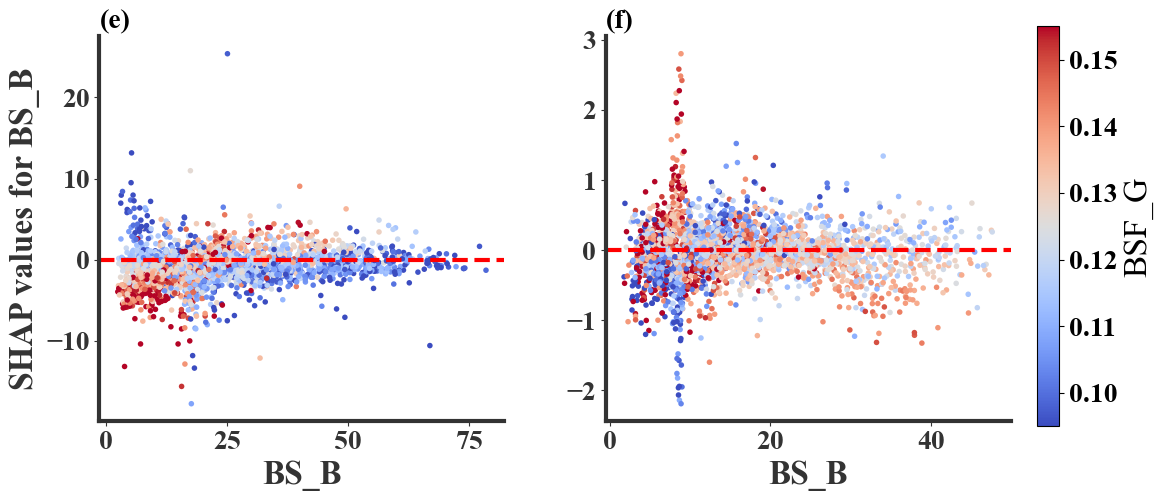

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colorbar as cbar


fig, axs = plt.subplots(1, 2, figsize=(15, 5))

fig.subplots_adjust(right=0.8, wspace=0, hspace=0.2)


shap.dependence_plot(
    "BS_B",  # key feature
    asisi[:, :, selected_X_test_asi.columns.get_loc("BSF_G")],  
    selected_X_test_asi,
    interaction_index="BSF_G",  # interactive feature
    ax=axs[1],
    show=False,
    cmap=plt.get_cmap('coolwarm')
)
# cbar = plt.colorbar(cax=axs[0,3], orientation='vertical')
# cbar.ax.set_visible(False)
cbar = axs[1].collections[0].colorbar
cbar.ax.set_visible(False)

axs[1].set_xlabel('BS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
axs[1].set_ylabel('', fontsize=2, fontname='Times New Roman', fontweight='bold')
axs[1].spines['bottom'].set_linewidth(3)  
axs[1].spines['top'].set_linewidth(3)  
axs[1].spines['left'].set_linewidth(3) 
axs[1].spines['right'].set_linewidth(3) 
axs[1].tick_params(axis='x', labelsize=20)
axs[1].tick_params(axis='y', labelsize=20)
axs[1].set_title('(f)', loc='left', fontsize=20, fontname='Times New Roman', fontweight='bold')
axs[1].axhline(0, color='red', linestyle='--', linewidth=3)
# axs[0, 0].imshow(data2, cmap='viridis')


shap.dependence_plot(
    "BS_B",  # key feature
    sgpsi[:, :, selected_X_test_sgp.columns.get_loc("BSF_G")],  
    selected_X_test_sgp,
    interaction_index="BSF_G",  # interactive feature
    ax=axs[0],
    show=False,
    cmap=plt.get_cmap('coolwarm')
)
# cbar = plt.colorbar(cax=axs[0,3], orientation='vertical')
# cbar.ax.set_visible(False)
cbar = axs[0].collections[0].colorbar
cbar.ax.set_visible(False)

axs[0].set_xlabel('BS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
axs[0].set_ylabel('SHAP values for BS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
axs[0].spines['bottom'].set_linewidth(3)  
axs[0].spines['top'].set_linewidth(3)  
axs[0].spines['left'].set_linewidth(3) 
axs[0].spines['right'].set_linewidth(3) 
axs[0].tick_params(axis='x', labelsize=20)
axs[0].tick_params(axis='y', labelsize=20)
axs[0].set_title('(e)', loc='left', fontsize=20, fontname='Times New Roman', fontweight='bold')
axs[0].axhline(0, color='red', linestyle='--', linewidth=3)


cbar_ax = fig.add_axes([0.75, 0.1, 0.015, 0.8]) 
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('coolwarm'))
sm.set_array([0.095,0.10,0.11,0.12,0.13,0.14,0.15,0.155])  
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.tick_params(labelsize=20)  
cbar.set_label('BSF_G', fontsize=24)  

# plt.savefig('E:/aabc/summary/fig-240804/eabsf.png',dpi=300,bbox_inches='tight',pad_inches=0)

plt.show()
